In [198]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing import image

from sklearn.model_selection import train_test_split

In [199]:
data_dir = 'DataL2'
image_files = os.listdir(data_dir)

# Paramètres des images
img_height, img_width, rgb = 128, 128, 3
input_img = Input(shape=(img_height, img_width, rgb))
images = []

for img_file in image_files:
    img_path = os.path.join(data_dir, img_file)
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    images.append(img_array)

images = np.array(images)

print("Chargement terminé.")

Chargement terminé.


In [200]:
# Afficher quelques informations de base sur les données
print(f"Nombre total d'images : {images.shape[0]}")
print(f"Dimensions des images : {images.shape[1:]}")
print(f"Valeur min des pixels : {np.min(images)}")
print(f"Valeur max des pixels : {np.max(images)}")

Nombre total d'images : 148
Dimensions des images : (128, 128, 3)
Valeur min des pixels : 0.0
Valeur max des pixels : 255.0


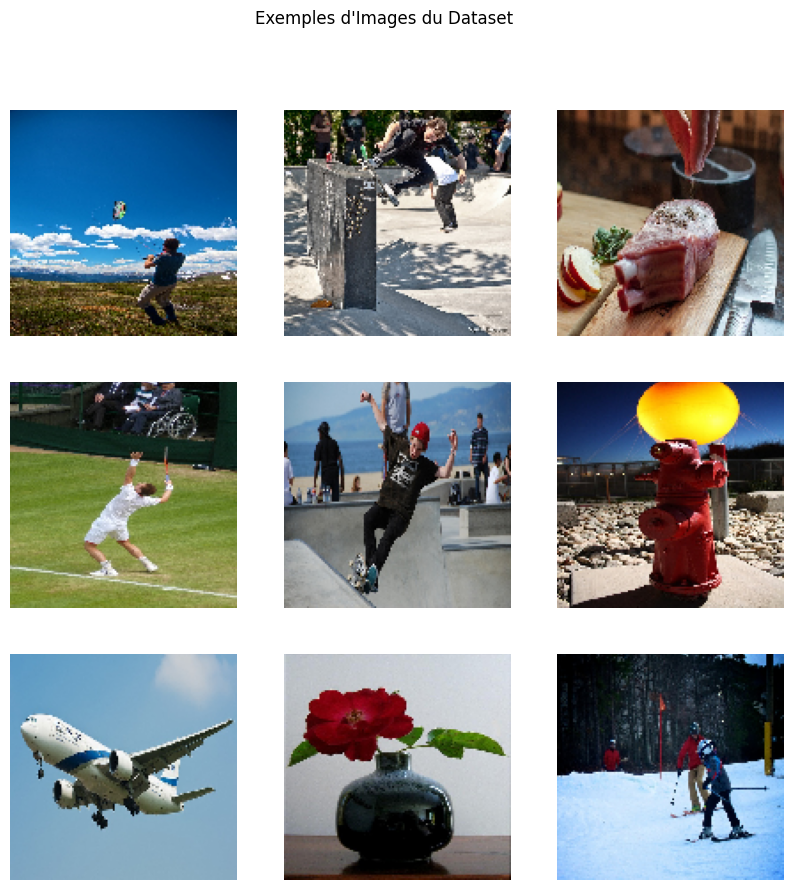

In [201]:
# Afficher quelques images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].astype('uint8'))
    plt.axis('off')
plt.suptitle('Exemples d\'Images du Dataset')
plt.show()

In [202]:
# Normaliser les images pour que les valeurs de pixel soient dans [0, 1]
normalized_images = images / 255.0

print("Normalisation terminé.")

Normalisation terminé.


In [203]:
# Paramètres pour l'ajout de bruit
noise_factor_015 = 0.15
noise_factor_040 = 0.40

# Ajout d'un bruit gaussien léger aux images
noisy_images_015 = normalized_images + noise_factor_015 * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images_015 = np.clip(noisy_images_015, 0., 1.)

# Ajout d'un bruit gaussien fort aux images
noisy_images_040 = normalized_images + noise_factor_040 * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images_040 = np.clip(noisy_images_040, 0., 1.)

print("Bruitage terminé.")

Bruitage terminé.


In [204]:
# Diviser les données en ensembles d'entraînement et de test
X_train_015, X_test_015, y_train_015, y_test_015 = train_test_split(
    noisy_images_015,   # Entrée (images bruitées)
    normalized_images,  # Cibles (images originales)
    test_size=0.2,
    random_state=42
)

# Diviser les données en ensembles d'entraînement et de test
X_train_040, X_test_040, y_train_040, y_test_040 = train_test_split(
    noisy_images_040,   # Entrée (images bruitées)
    normalized_images,  # Cibles (images originales)
    test_size=0.2,
    random_state=42
)

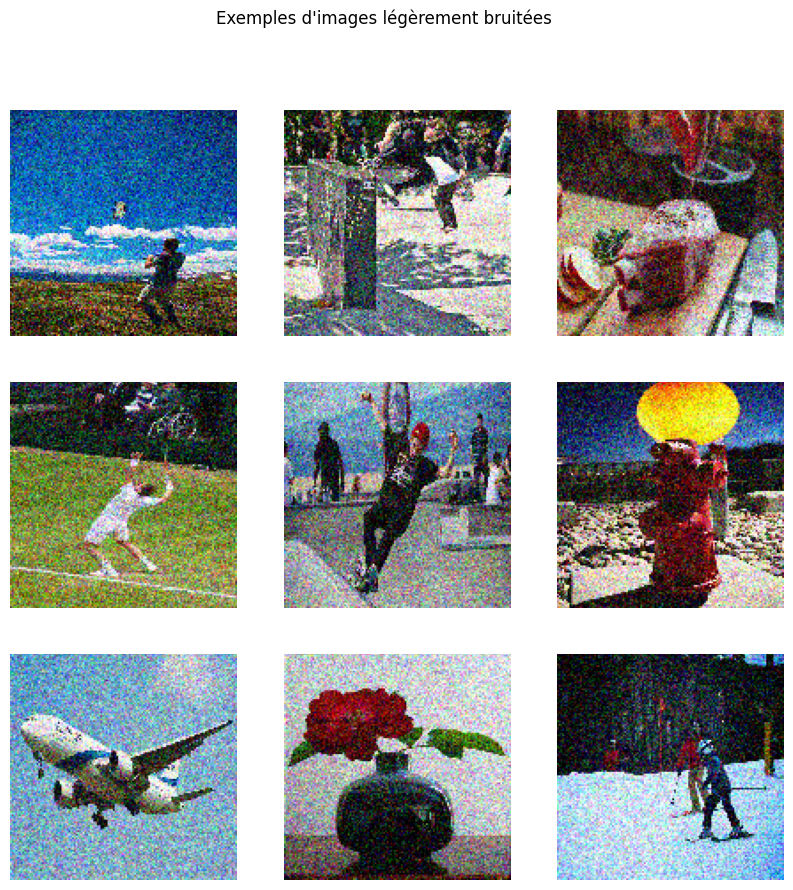

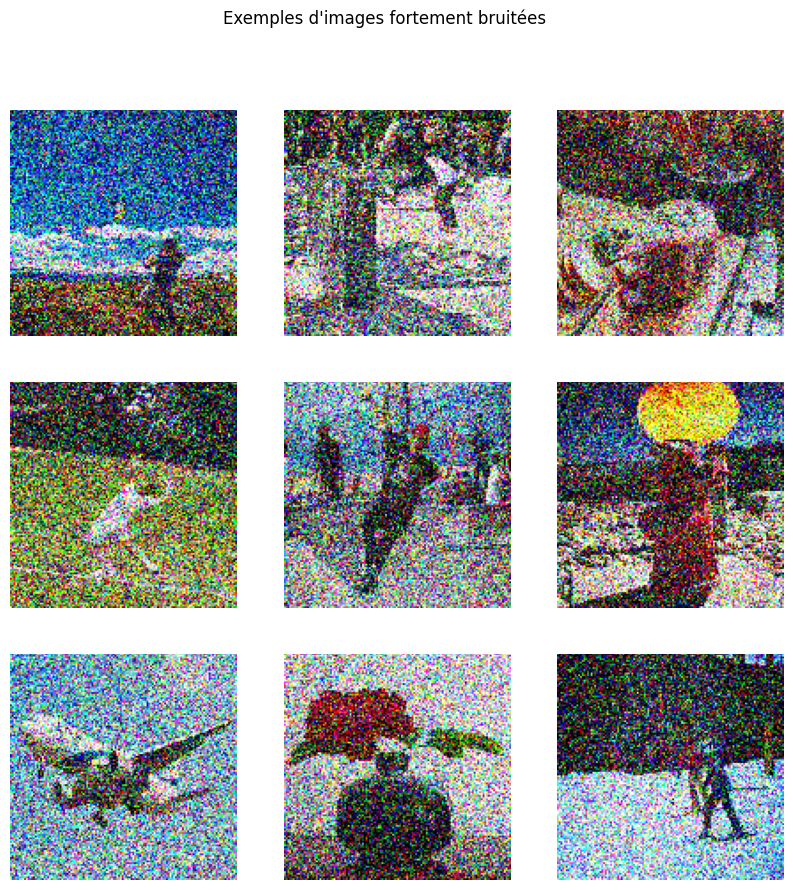

In [205]:
# Afficher quelques images légèrement bruitées
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(noisy_images_015[i].astype('float32'))
    plt.axis('off')
plt.suptitle('Exemples d\'images légèrement bruitées')
plt.show()

# Afficher quelques images fortement bruitées
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(noisy_images_040[i].astype('float32'))
    plt.axis('off')
plt.suptitle('Exemples d\'images fortement bruitées')
plt.show()

In [206]:
# Coding the specific sampling layer as a Keras Layer object
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_logvar = inputs

        nbatch = K.shape(z_mean)[0]
        ndim = K.shape(z_mean)[1]

        std = K.exp(z_logvar)
        eps = K.random_normal(shape=(nbatch,ndim), mean=0., stddev=0.1)

        z = z_mean + eps * std
        
        print(z.shape)
        
        return z

In [207]:
encoder_inputs = keras.Input(shape=(img_height, img_width, rgb))

x = layers.Flatten()(encoder_inputs)  # Flatten the RGB image

hidden1 = layers.Dense(200, activation="relu")(x)

z_mean = layers.Dense(128)(hidden1)
z_logvar = layers.Dense(128)(hidden1)

# Sampling
encoder_outputs = Sampling()([z_mean, z_logvar])

print(encoder_outputs.shape)

encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")


(None, 128)
(None, 128)


In [208]:
# Decoder architecture
decoder_inputs = keras.Input(shape=(128,))

x = layers.Dense(200, activation="relu")(decoder_inputs)

x = layers.Dense(img_height * img_width * rgb, activation="sigmoid")(x)

# Divisez le tenseur en trois parties pour les canaux RVB
red_channel = layers.Lambda(lambda x: x[:, :128*128])(x)
green_channel = layers.Lambda(lambda x: x[:, 128*128:2*128*128])(x)
blue_channel = layers.Lambda(lambda x: x[:, 2*128*128:])(x)

# Reshapez chaque canal en (128, 128, 1)
red_channel = layers.Reshape((128, 128, 1))(red_channel)
green_channel = layers.Reshape((128, 128, 1))(green_channel)
blue_channel = layers.Reshape((128, 128, 1))(blue_channel)


# Concaténez les trois canaux pour obtenir une image RVB complète
decoder_outputs = layers.Concatenate()([red_channel, green_channel, blue_channel])


decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")


In [209]:
# Combining architectures

print(encoder_inputs.shape)
print(encoder_outputs.shape)
print(decoder_inputs.shape)
print(decoder_outputs.shape)
outputs = decoder(encoder_outputs)
print(outputs.shape)
vae = keras.Model(encoder_inputs, outputs, name="vae")

(None, 128, 128, 3)
(None, 128)
(None, 128)
(None, 128, 128, 3)
(None, 128, 128, 3)


In [210]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_83 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 flatten_27 (Flatten)        (None, 49152)                0         ['input_83[0][0]']            
                                                                                                  
 dense_177 (Dense)           (None, 200)                  9830600   ['flatten_27[0][0]']          
                                                                                                  
 dense_178 (Dense)           (None, 128)                  25728     ['dense_177[0][0]']           
                                                                                                

In [211]:
# Compiling the model
vae.compile(optimizer='adam', loss='mse', metrics=['accuracy'] )

In [212]:
# Fitting the model
history = vae.fit(X_train_015, X_train_015,
                  epochs=30,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(X_test_015, X_test_015))

Epoch 1/30
(None, 128)
(None, 128)
1/1 [==============================] - 2s 2s/step - loss: 0.0905 - accuracy: 0.3340 - val_loss: 0.0880 - val_accuracy: 0.3336
Epoch 2/30
1/1 [==============================] - 0s 89ms/step - loss: 0.0911 - accuracy: 0.3347 - val_loss: 0.3125 - val_accuracy: 0.3331
Epoch 3/30
1/1 [==============================] - 0s 69ms/step - loss: 0.3105 - accuracy: 0.3471 - val_loss: 0.2180 - val_accuracy: 0.3357
Epoch 4/30
1/1 [==============================] - 0s 64ms/step - loss: 0.2179 - accuracy: 0.3388 - val_loss: 0.1153 - val_accuracy: 0.3388
Epoch 5/30
1/1 [==============================] - 0s 78ms/step - loss: 0.1178 - accuracy: 0.3445 - val_loss: 0.0893 - val_accuracy: 0.3381
Epoch 6/30
1/1 [==============================] - 0s 89ms/step - loss: 0.0915 - accuracy: 0.3458 - val_loss: 0.0881 - val_accuracy: 0.3380
Epoch 7/30
1/1 [==============================] - 0s 79ms/step - loss: 0.0906 - accuracy: 0.3479 - val_loss: 0.0879 - val_accuracy: 0.3388
Epoch

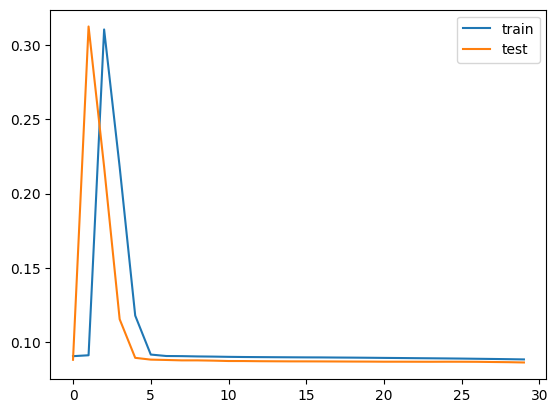

In [213]:
# Visualizing the training and validation losses
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

(None, 128)
1/1 [==============================] - 0s 15ms/step


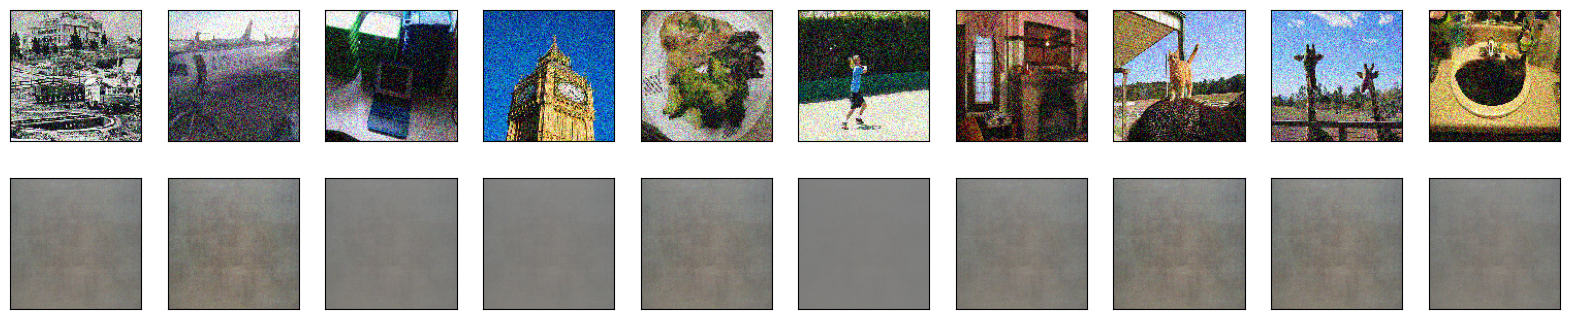

In [214]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_015[i].reshape(128, 128, 3), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    encoded_img = encoder.predict(np.array([X_test_015[i]]).reshape(1,128, 128, 3))
    decoded_img = decoder.predict(encoded_img).reshape(128, 128, 3)
    plt.imshow(decoded_img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()